# 🧠 MS Lesion Synthesis Inference Notebook

In [5]:
import torch
from diffusers import (
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
    DDIMScheduler,
    PNDMScheduler,
    EulerAncestralDiscreteScheduler,
    LCMScheduler)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
import pandas as pd


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
seed = 17844

In [6]:
def print_info(var, name):
    print(f"{name}:")
    print(f"  Type: {type(var)}")
    if hasattr(var, 'shape'):
        print(f"  Shape: {var.shape}")
    elif hasattr(var, 'size'):  # for PIL.Image
        print(f"  Size (width, height): {var.size}")
    else:
        print("  No shape or size attribute.")
    print()
    
def load_image(path, size=256, show=True, info=True):
    image = Image.open(path).convert('RGB')
    image = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        # # to tensor
        # transforms.ToTensor(),
    ])(image)

    if show:
        plt.imshow(image)
        plt.title("Loaded image")
        plt.show()
        print(f"Image {path} loaded. Size: {image.size}, mode: {image.mode}")
    
    if info:
        print_info(image, "Image")

    return image

def generate_mask(image, mask_size, mask_position, show=True, info=True):
    if isinstance(image, Image.Image):
        image = transforms.ToTensor()(image)

    
    mask = torch.zeros_like(image[0])
    mask[mask_position[0]:mask_position[0]+mask_size[0], mask_position[1]:mask_position[1]+mask_size[1]] = 1
    
    # convert to PIL image
    mask = transforms.ToPILImage()(mask)

    if show:
        plt.imshow(mask)
        plt.title("Generated mask")
        plt.show()
        print(f"Mask generated. Size: {mask_size}, position: {mask_position}")
    
    if info:
        print_info(mask, "Mask")

    return mask

def generate_lesion(pipe, image, mask, prompt, guidance, inference_steps=25, device='cuda', seed=17844, show=True, info=True):
    generator = torch.Generator(device=device).manual_seed(seed)
    result = pipe(prompt=prompt,
                image=image,
                mask_image=mask,
                num_inference_steps=inference_steps,
                generator=generator,
                guidance=guidance, #guidance_scale??
                ).images[0]
    if show:
        plt.imshow(result)
        plt.title("Generated lesion")
        plt.show()

    if info:
        print_info(result, "Generated lesion")
    
    return result


def lesion_difference(original_image, generated_image, mask, show=True, info=True):
    """
    Plot the original image, generated image, their absolute difference,
    and the lesion mask.
    All inputs must be PIL Images or tensors of the same size.
    """
    # Convert images to tensors (C, H, W) normalized to [0,1]
    def to_tensor_if_needed(img):
        return img if isinstance(img, torch.Tensor) else to_tensor(img)

    original_tensor = to_tensor_if_needed(original_image)
    generated_tensor = to_tensor_if_needed(generated_image)
    
    # Compute absolute difference
    diff_tensor = torch.abs(original_tensor - generated_tensor)
    diff_image = diff_tensor.mean(dim=0)  # Grayscale diff for visualization

    # Prepare mask tensor
    mask_tensor = to_tensor_if_needed(mask)
    if mask_tensor.dim() == 3 and mask_tensor.shape[0] == 1:
        mask_tensor = mask_tensor[0]  # Remove channel dim if needed

    # Convert all for imshow (NumPy, H x W or H x W x 3)
    original_np = original_tensor.permute(1, 2, 0).numpy()
    generated_np = generated_tensor.permute(1, 2, 0).numpy()
    diff_np = diff_image.numpy()
    mask_np = mask_tensor.numpy()

    if show:
        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        
        axs[0].imshow(original_np)
        axs[0].set_title("Original Image")
        axs[0].axis("off")
        
        axs[1].imshow(generated_np)
        axs[1].set_title("Generated Image")
        axs[1].axis("off")
        
        axs[2].imshow(diff_np, cmap='gray')
        axs[2].set_title("Difference Map")
        axs[2].axis("off")
        
        axs[3].imshow(mask_np, cmap='gray')
        axs[3].set_title("Mask")
        axs[3].axis("off")

        plt.suptitle("Original vs Generated Lesion")
        plt.tight_layout()
        plt.show()
    
    diff_max, diff_mean = diff_tensor.max().item(), diff_tensor.mean().item()
    if info:    
        print("Diff max:", diff_max)
        print("Diff mean:", diff_mean)
        
    return diff_tensor, diff_max, diff_mean




In [11]:
# ---- Load pipeline ----
model_path = "../lesion-inpating-dreambooth-model-new"        # <- Replace this with your fine-tuned model folder
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    safety_checker=None,
)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.set_progress_bar_config(disable=True)
pipe = pipe.to(device)
# inspect.signature(pipe.__call__)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


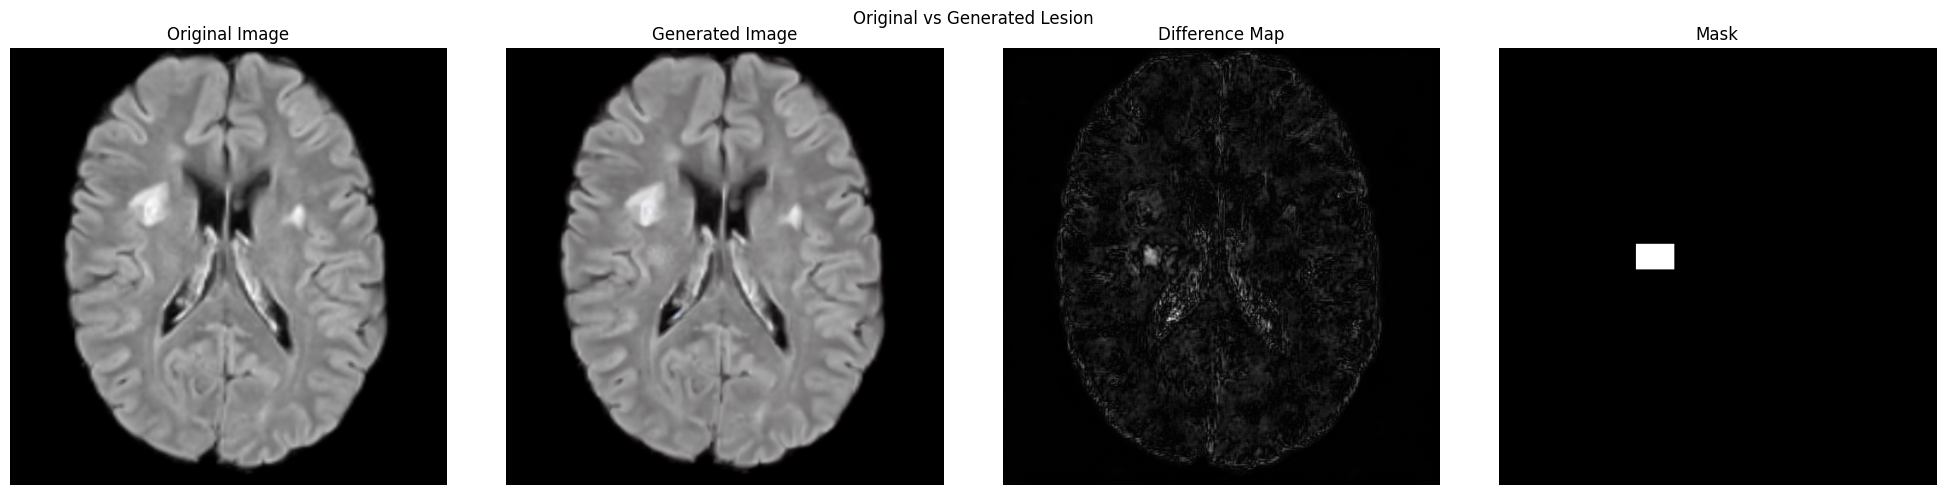

Diff max: 0.2352941334247589
Diff mean: 0.009434419684112072


In [15]:
image_path = "./input_data/flair2.png"                     # <- Path to FLAIR MRI image (PNG, JPG)
prompt = "MS lesion in an axial FLAIR MRI brain scan."           # <- Prompt for the model
output_path = "./output_data/lesion_output.png"           # <- Where to save the output
image_size = 512  # Assumes model was trained at 512x512
guidance = 7.5
mask_size = (30, 45)
mask_position = (230, 160)

# Load image and mask
image = load_image(image_path, image_size, show=False, info=False)

# Generate mask
mask = generate_mask(image, mask_size, mask_position, show=False, info=False)

# Generate lesion
lesion = generate_lesion(pipe, image, mask, prompt, guidance, device=device, show=False, info=False)

# Plot results
_ = lesion_difference(image, lesion, mask, show=True, info=True)

Experiment trying different inference strategies for the MS Lesion Synthesis task to see which parameters work best.

In [ ]:
# # === Config ===

# image_size = 512

# image_paths = [
#     "./input_data/flair.png",
#     "./input_data/flair1.png",
#     "./input_data/flair2.png"
# ]

# prompts = [
#     "Multiple sclerosis lesion inpainting",
#     "Hyperintense lesion",
#     "MS lesion in an axial FLAIR MRI brain scan."
# ]

# guidance_values = [7.5, 10, 15]
# inference_steps_list = [25, 50]

# mask_configs = [
#     ((250, 150), (20, 25)),
#     ((150, 400), (30, 30)),
#     ((400, 200), (40, 35))
# ]

# schedulers = {
#     "DPM": DPMSolverMultistepScheduler,
#     "DDIM": DDIMScheduler,
#     "PNDM": PNDMScheduler,
#     "EulerA": EulerAncestralDiscreteScheduler
# }

# # === Metric logger ===
# metrics = []

# # === Main loop ===
# for scheduler_name, scheduler_cls in schedulers.items():
#     print(f"\n== Testing Scheduler: {scheduler_name} ==")

#     pipe.scheduler = scheduler_cls.from_config(pipe.scheduler.config)

#     for img_path in image_paths:
#         image_name = os.path.basename(img_path)
#         image = load_image(img_path, image_size, show=False, info=False)

#         for (mask_position, mask_size) in mask_configs:
#             mask = generate_mask(image, mask_size, mask_position, show=False, info=False)

#             for prompt in prompts:
#                 for guidance in guidance_values:
#                     for inference_steps in inference_steps_list:
#                         print(f"\nImage: {image_name} | Scheduler: {scheduler_name} | Prompt: \"{prompt}\" | "
#                               f"Guidance: {guidance} | Steps: {inference_steps} | Mask: {mask_position}, {mask_size}")

#                         lesion = generate_lesion(pipe, image, mask, prompt, guidance,
#                                                  inference_steps=inference_steps,
#                                                  device=device, show=False, info=False)

#                         _, diff_max, diff_mean = lesion_difference(image, lesion, mask, show=False, info=False)

#                         metrics.append({
#                             "image": image_name,
#                             "scheduler": scheduler_name,
#                             "prompt": prompt,
#                             "guidance": guidance,
#                             "inference_steps": inference_steps,
#                             "mask_position": mask_position,
#                             "mask_size": mask_size,
#                             "diff_max": diff_max,
#                             "diff_mean": diff_mean
#                         })

# df = pd.DataFrame(metrics)
# df_sorted = df.sort_values(by="diff_max", ascending=False)
# df_sorted.to_csv("output_data/lesion_generation_metrics.csv", index=False)

In [4]:
# Display as nice HTML table in Jupyter/Colab
from IPython.display import display

# load df from csv
df_sorted = pd.read_csv("output_data/lesion_generation_metrics.csv")

display(df_sorted)

,image,scheduler,prompt,guidance,inference_steps,mask_position,mask_size,diff_max,diff_mean
0,flair1.png,EulerA,Multiple sclerosis lesion inpainting,15.0,50,"(150, 400)","(30, 30)",0.545098,0.007367
1,flair1.png,EulerA,Multiple sclerosis lesion inpainting,10.0,50,"(150, 400)","(30, 30)",0.545098,0.007367
2,flair1.png,EulerA,Multiple sclerosis lesion inpainting,7.5,50,"(150, 400)","(30, 30)",0.545098,0.007367
3,flair.png,EulerA,Hyperintense lesion,15.0,50,"(150, 400)","(30, 30)",0.541176,0.006734
4,flair.png,EulerA,Hyperintense lesion,10.0,50,"(150, 400)","(30, 30)",0.541176,0.006734
...,...,...,...,...,...,...,...,...,...
643,flair.png,EulerA,MS lesion in an axial FLAIR MRI brain scan.,10.0,25,"(250, 150)","(20, 25)",0.121569,0.006393
644,flair.png,EulerA,MS lesion in an axial FLAIR MRI brain scan.,15.0,25,"(250, 150)","(20, 25)",0.121569,0.006393
645,flair.png,EulerA,MS lesion in an axial FLAIR MRI brain scan.,15.0,50,"(250, 150)","(20, 25)",0.117647,0.006544
646,flair.png,EulerA,MS lesion in an axial FLAIR MRI brain scan.,7.5,50,"(250, 150)","(20, 25)",0.117647,0.006544
